In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb


# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

done!

**Task2**:

What is a decision tree? How do they work?

A decision tree is a simple way to make predictions by asking a series of yes/no questions. It starts with one question about the data (like “Is age > 30?”), then based on the answer, it asks another question, and so on. Each question splits the data into smaller groups. At the end of the path, the tree gives a final answer or prediction. It’s like playing 20 Questions to figure something out.


**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is how many questions it asks in a row before making a final decision. If the tree is too deep, it might remember the training data too well and mess up on new data — overfitting. If it’s not deep enough, it might not ask enough questions to make good decisions — underfitting. You want the depth to be just right so the tree learns patterns without getting confused or too picky.


To find the right depth, you monitor performance on both training and validation data, and aim for a balance









**Task4:**

How are BART models similar and different from a decision tree?

BART (Bayesian Additive Regression Trees) is kind of like using a whole team of decision trees instead of just one. Each tree in BART is small and simple, and on their own they don’t do much, but when you add all their predictions together, you get a strong final answer. This is different from a regular decision tree, which makes one big set of decisions all by itself. BART also uses some math to help control how the trees are built and avoid overfitting. So BART is smarter and more careful

**Task5**:

Why would we use a BART model instead of a decision tree?

We use BART instead of a decision tree because it gives better, more reliable predictions. It combines many small trees instead of relying on one big one, which helps reduce overfitting and handle complex data better. Plus, it gives uncertainty estimates, which regular trees don’t.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [2]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [3]:
feat_x = penguins[["flipper_length", "bill_length","bill_depth"]]
body_y = penguins["body_mass"].to_numpy()

In [4]:
with pm.Model() as model_peng:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", feat_x, np.log(body_y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=body_y)
    idata_peng = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

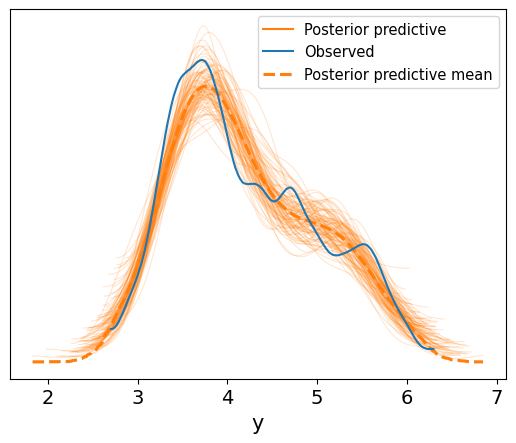

In [6]:
pm.sample_posterior_predictive(idata_peng,model_peng, extend_inferencedata=True)
az.plot_ppc(idata_peng, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [7]:
posterior_mean = idata_peng.posterior["μ"]

μ_hdi = az.hdi(ary=idata_peng, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_peng, group="posterior_predictive", var_names=["y"]
).T

In [8]:
Xn = feat_x.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


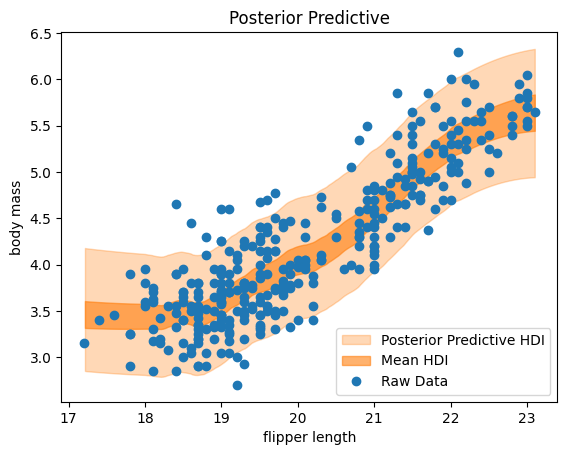

In [13]:
idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper length",
    ylabel="body mass",
);


**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think the plot mostly captures the relationship between flipper length and body mass. You can see the orange band follows the upward trend of the data points pretty well, especially after flipper length hits like 19 or 20. The predictions match the raw data in the middle and upper range, even though there’s a bit more spread in the lower flipper lengths.



**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

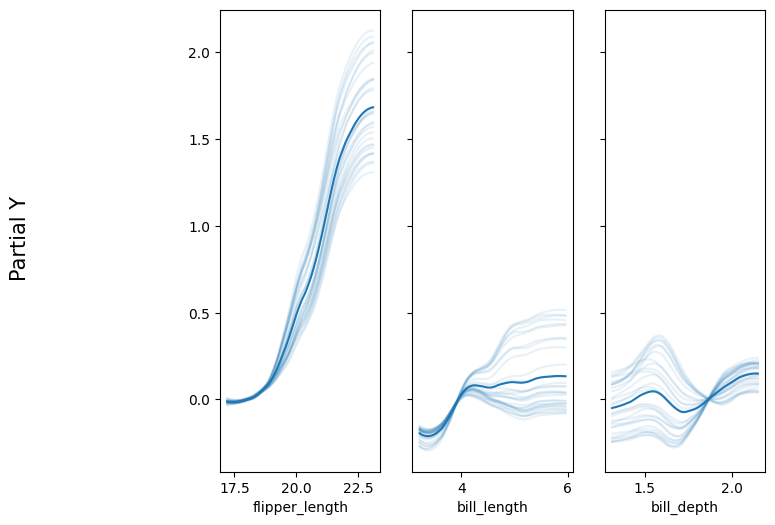

In [15]:
pmb.plot_ice( μ_, feat_x, body_y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

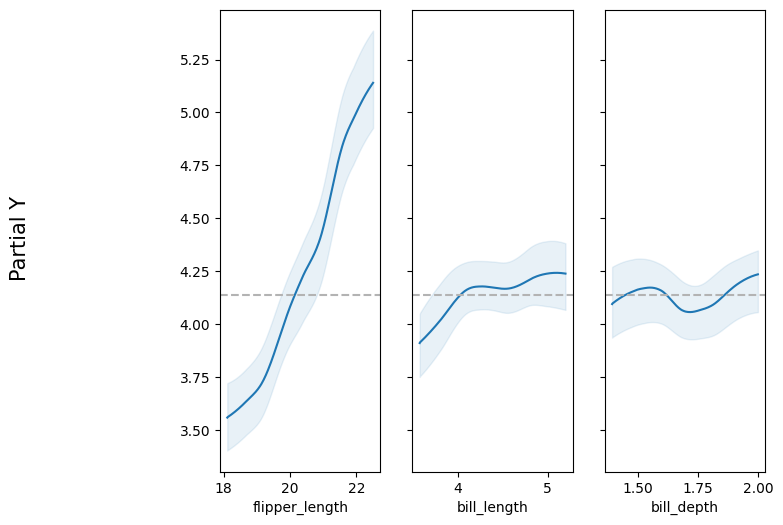

In [14]:
pmb.plot_pdp(μ_, feat_x, body_y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

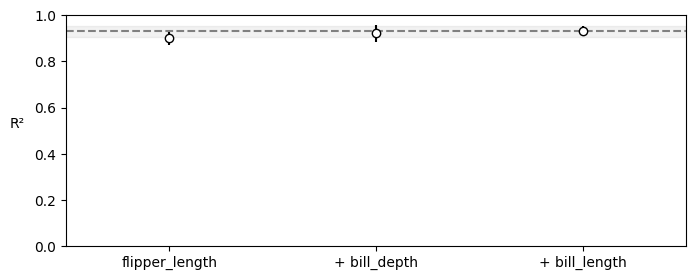

In [16]:
vi_counties = pmb.compute_variable_importance(idata_peng, μ_, feat_x)
pmb.plot_variable_importance(vi_counties)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Variable Importance:


Flipper length—it has a steep curve in the first plot and adds most of the R² in the third plot, while the other variables barely help.


---


Body Mass:


Longer flippers lead to heavier penguins, shown by the strong upward trend. Bill length and depth have flat lines, so not much impact.


---


Interactions:

Doesn’t look like it—the second plot shows most lines follow the same shape, especially for bill features, so variables don’t seem to affect each other much.














